## Bots and Gender Profiling
https://pan.webis.de/clef19/pan19-web/author-profiling.html

####  data preprocessing

In [1]:
import ssl
import html
import IPython
import matplotlib.pyplot as plt
import nltk
import os
import pandas as pd
import re
import seaborn as sns
import sys
import xml.etree.ElementTree as ElementTree

from dataset import Dataset
from itertools import zip_longest
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from pathlib import Path

# https://stackoverflow.com/questions/38916452/nltk-download-ssl-certificate-verify-failed
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

#tokenizer
nltk.download('punkt')
#stopwords
nltk.download('stopwords')
#lemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/ianic/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/ianic/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ianic/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
dataset = Dataset(Path("/Users/ianic/Documents/pan19/pan19-author-profiling-training-2019-02-18/en"),
  Path("/Users/ianic/Documents/pan19/pan19-author-profiling-training-2019-02-18/en_labels/truth.txt"),
  Path("/Users/ianic/Documents/pan19/pan19-author-profiling-test-2019-04-29/en"),
  Path("/Users/ianic/Documents/pan19/pan19-author-profiling-test-2019-04-29/truth.txt"))

xtrain, ytrain, xtest, ytest = dataset.get_data()
print(len(xtrain), len(ytrain))
print(len(xtest), len(ytest))

4120 4120
2640 2640


In [3]:
d = {'author': [], 'tweet': [], 'bot': []}
for author in xtrain:
    for tweet in xtrain[author]:
        d['author'].append(author)
        d['tweet'].append(tweet)
        d['bot'].append(ytrain[author][0])

df_train = pd.DataFrame(d, columns=['author', 'tweet', 'bot'])

d = {'author': [], 'tweet': [], 'bot': []}
for author in xtest:
    for tweet in xtest[author]:
        d['author'].append(author)
        d['tweet'].append(tweet)
        d['bot'].append(ytest[author][0])

df_test = pd.DataFrame(d, columns=['author', 'tweet', 'bot'])

print(f"train size: {df_train.shape}, test size: {df_test.shape}")

train size: (412000, 3), test size: (264000, 3)


In [4]:
# complete dataset
df = pd.concat([df_train, df_test])
print(f"df size: {df.shape}")
df

df size: (676000, 3)


,author,tweet,bot
0,7fbb9ceb600ebc6fcadc9ee235cda580,"During a brief chat, Hope Hicks accidentally c...",bot
1,7fbb9ceb600ebc6fcadc9ee235cda580,"Sighing deeply, Lamar Smith informs President ...",bot
2,7fbb9ceb600ebc6fcadc9ee235cda580,"At a playground, Stephen Miller mistakenly tel...",bot
3,7fbb9ceb600ebc6fcadc9ee235cda580,"On the South Lawn, Louie Gohmert persuades Jef...",bot
4,7fbb9ceb600ebc6fcadc9ee235cda580,"In the West Wing, Sean Spicer boldly informs K...",bot
...,...,...,...
263995,5b08ce74a6faab9dce6fb2ca6b1a3a45,"My goodness, Boys #raptors",human
263996,5b08ce74a6faab9dce6fb2ca6b1a3a45,Denim. All. The. Time. https://t.co/Bc9EHH21BD,human
263997,5b08ce74a6faab9dce6fb2ca6b1a3a45,BIG COOOOOWS https://t.co/rR5MqOU7ux,human
263998,5b08ce74a6faab9dce6fb2ca6b1a3a45,RT @evilbmcats: I am the bringer of sorrow. I ...,human


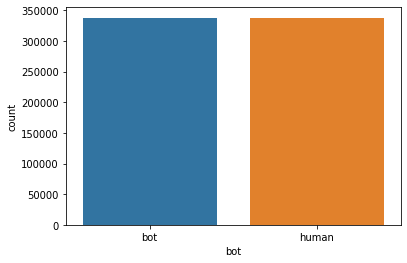

In [5]:
sns.countplot(df['bot'])

## Preproc

In [3]:
tokenizer = TweetTokenizer()
lemmatizer = WordNetLemmatizer() 

def replace_num_token(text, replace_with = ''):
    """ Replace all numbers with a unique token.
    """
    text = re.sub(r"\d+", replace_with, text).strip()
    return text

def clean_text(text):    
    # lowercase 
    text = text.lower()
    
    # remove urls
    text = re.sub(r"http\S+|www\S+|https\S+", 'URL_TOKEN', text, flags=re.MULTILINE)
    
    # maybe strip tags
    text = re.sub(r'\@\w+|\#','', text)
    
    # strip html tags
    text = html.unescape(text)
    
    # remove non-words
    text = re.sub('\W', ' ', text)
    
    # remove single chars
    text = re.sub(r'(?:^| )\w(?:$| )', ' ', text)
    
    # replace numbers with NUM_TOKEN
    text = replace_num_token(text, 'NUM_TOKEN')
    
    # tokenize
    tokenized = tokenizer.tokenize(text)
    tokenized = list(map(lambda x : lemmatizer.lemmatize(x), tokenized))

    # remove stopwords
    words = [w for w in tokenized if not w in stopwords.words('english')]

    return " ".join(words)
  

In [10]:
df_train['clean_tweet'] = df_train['tweet'].apply(lambda x: clean_text(x))
df_train

,author,tweet,bot,clean_tweet
0,7fbb9ceb600ebc6fcadc9ee235cda580,"During a brief chat, Hope Hicks accidentally c...",bot,brief chat hope hick accidentally convinces pr...
1,7fbb9ceb600ebc6fcadc9ee235cda580,"Sighing deeply, Lamar Smith informs President ...",bot,sighing deeply lamar smith informs president t...
2,7fbb9ceb600ebc6fcadc9ee235cda580,"At a playground, Stephen Miller mistakenly tel...",bot,playground stephen miller mistakenly tell bets...
3,7fbb9ceb600ebc6fcadc9ee235cda580,"On the South Lawn, Louie Gohmert persuades Jef...",bot,south lawn louie gohmert persuades jeff sessio...
4,7fbb9ceb600ebc6fcadc9ee235cda580,"In the West Wing, Sean Spicer boldly informs K...",bot,west wing sean spicer boldly informs kellyanne...
...,...,...,...,...
411995,b58ced882574852ce6dcc055256d4767,"RT @BRK_B: #Apple, @Google, Berkshire: The Sto...",bot,rt apple berkshire stock investor want christm...
411996,b58ced882574852ce6dcc055256d4767,$BRK.B - Berkshire Hathaway Stock Analysis - b...,bot,brk berkshire hathaway stock analysis bullish ...
411997,b58ced882574852ce6dcc055256d4767,"RT @BRK_B: #Apple, @Google, Berkshire: The Sto...",bot,rt apple berkshire stock investor want christm...
411998,b58ced882574852ce6dcc055256d4767,"RT @BRK_B: #Apple, @Google, Berkshire: The Sto...",bot,rt apple berkshire stock investor want christm...


In [11]:
df_test['clean_tweet'] = df_test['tweet'].apply(lambda x: clean_text(x))
df_test

,author,tweet,bot,clean_tweet
0,8858698352752082c81d1d32b999e1e,When your phone keeps autocorrecting tour to y...,human,phone keep autocorrecting tour
1,8858698352752082c81d1d32b999e1e,On a day like this get this in your ears!! #is...,human,day like get ear isleybrothers summerbreeze UR...
2,8858698352752082c81d1d32b999e1e,A glorious day in London! 😎☀️,human,glorious day london
3,8858698352752082c81d1d32b999e1e,@JHChristEsq nice job in GOT dude :),human,nice job got dude
4,8858698352752082c81d1d32b999e1e,@nategroove what!!!,human,
...,...,...,...,...
263995,5b08ce74a6faab9dce6fb2ca6b1a3a45,"My goodness, Boys #raptors",human,goodness boy raptor
263996,5b08ce74a6faab9dce6fb2ca6b1a3a45,Denim. All. The. Time. https://t.co/Bc9EHH21BD,human,denim time URL_TOKEN
263997,5b08ce74a6faab9dce6fb2ca6b1a3a45,BIG COOOOOWS https://t.co/rR5MqOU7ux,human,big cooooows URL_TOKEN
263998,5b08ce74a6faab9dce6fb2ca6b1a3a45,RT @evilbmcats: I am the bringer of sorrow. I ...,human,rt bringer sorrow harbinger death true terror ...


In [12]:
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = nltk.FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    # selecting top n most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(15,terms / 5))
    ax = sns.barplot(data=d, x= "count", y = "word", color='lightseagreen')
    ax.set(ylabel = 'Word')

    plt.show()
    return words_df.shape[0]

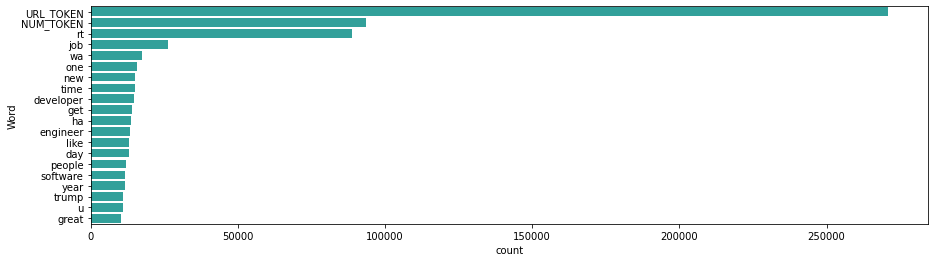

Number of distinct words in dataset: 122976


In [13]:
# print 20 most frequent words, with URL_TOKEN
size = freq_words(df_train['clean_tweet'], 20)
print(f"Number of distinct words in dataset: {size}")

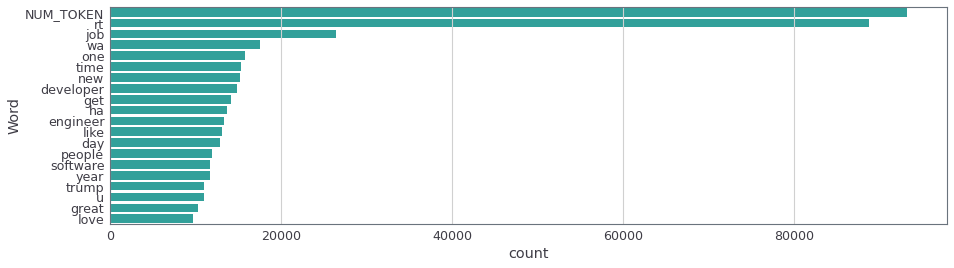

Number of distinct words in dataset: 201578


In [48]:
# print 20 most frequent words
size = freq_words(df_train['clean_tweet'], 20)
print(f"Number of distinct words in dataset: {size}")

In [14]:
df_train.to_pickle("./pan19_df_clean_train_no_uris.pkl")

In [15]:
df_test.to_pickle("./pan19_df_clean_test_no_uris.pkl")